In [72]:
!pip install yfinance

In [73]:
import pandas as pd
import yfinance  as yf
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

In [74]:
sp500 = yf.Ticker("^GSPC")
sp500 = sp500.history(period="max")

In [75]:
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2025-05-13 00:00:00-04:00,5854.149902,5906.640137,5845.020020,5886.549805,5516290000,0.0,0.0
2025-05-14 00:00:00-04:00,5896.740234,5906.549805,5872.109863,5892.580078,5233450000,0.0,0.0
2025-05-15 00:00:00-04:00,5869.819824,5924.209961,5865.160156,5916.930176,4991290000,0.0,0.0


In [76]:
sp500.index

DatetimeIndex(['1927-12-30 00:00:00-05:00', '1928-01-03 00:00:00-05:00',
               '1928-01-04 00:00:00-05:00', '1928-01-05 00:00:00-05:00',
               '1928-01-06 00:00:00-05:00', '1928-01-09 00:00:00-05:00',
               '1928-01-10 00:00:00-05:00', '1928-01-11 00:00:00-05:00',
               '1928-01-12 00:00:00-05:00', '1928-01-13 00:00:00-05:00',
               ...
               '2025-05-06 00:00:00-04:00', '2025-05-07 00:00:00-04:00',
               '2025-05-08 00:00:00-04:00', '2025-05-09 00:00:00-04:00',
               '2025-05-12 00:00:00-04:00', '2025-05-13 00:00:00-04:00',
               '2025-05-14 00:00:00-04:00', '2025-05-15 00:00:00-04:00',
               '2025-05-16 00:00:00-04:00', '2025-05-19 00:00:00-04:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=24461, freq=None)

<Axes: xlabel='Date'>

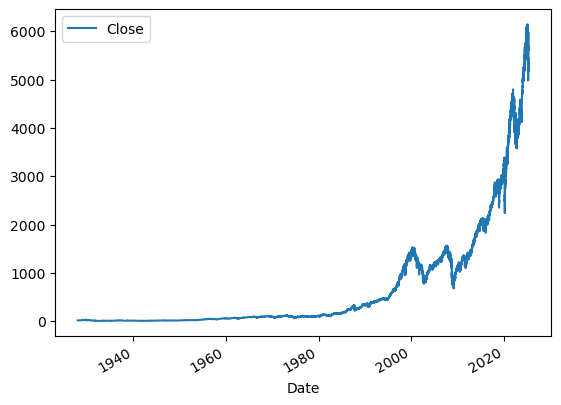

In [77]:
sp500.plot.line(y="Close", use_index=True)

In [78]:
del sp500["Dividends"]
del sp500["Stock Splits"]

In [79]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [80]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int) 

In [81]:
sp500 = sp500.loc["1990-01-01":].copy()

In [82]:
model = RandomForestClassifier(n_estimators=1000, min_samples_split=100, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, n_estimators=1000, random_state=1)

In [83]:
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)

In [84]:
preds

Date
2024-12-23 00:00:00-05:00    1
2024-12-24 00:00:00-05:00    1
2024-12-26 00:00:00-05:00    1
2024-12-27 00:00:00-05:00    1
2024-12-30 00:00:00-05:00    1
                            ..
2025-05-13 00:00:00-04:00    1
2025-05-14 00:00:00-04:00    1
2025-05-15 00:00:00-04:00    1
2025-05-16 00:00:00-04:00    1
2025-05-19 00:00:00-04:00    1
Length: 100, dtype: int32

In [85]:
precision_score(test["Target"], preds)

0.6071428571428571

In [86]:
combined = pd.concat([test["Target"], preds], axis=1)

<Axes: xlabel='Date'>

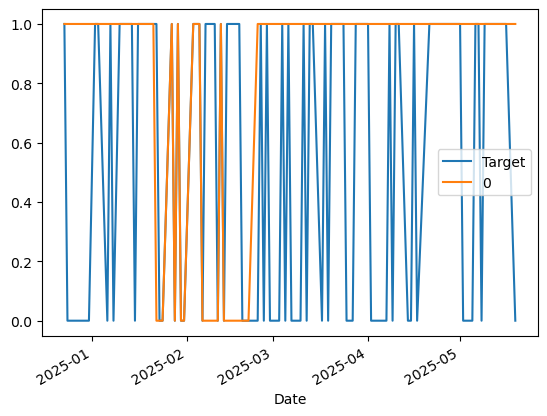

In [87]:
combined.plot()

In [88]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined
    

In [89]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = sp500.iloc[0:i].copy()
        test = sp500.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [90]:
predictions = backtest(sp500, model, predictors)

In [91]:
predictions["Predictions"].value_counts()

Predictions
0    3723
1    2688
Name: count, dtype: int64

In [92]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5331101190476191

In [93]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.536578
0    0.463422
Name: count, dtype: float64

In [94]:
horizons = [2, 5, 60, 250, 1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]

    trend_colomun = f"Trend_{horizon}"
    sp500[trend_colomun] = sp500.shift(1).rolling(horizon).sum()["Target"]

    new_predictors += [ratio_column, trend_colomun]

In [95]:
sp500 = sp500.dropna()

In [96]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1993-12-14 00:00:00-05:00,465.730011,466.119995,462.459991,463.059998,275050000,461.839996,0,0.997157,1.0,0.996617,1.0,1.000283,32.0,1.028047,127.0,1.176082,512.0
1993-12-15 00:00:00-05:00,463.059998,463.690002,461.839996,461.839996,331770000,463.339996,1,0.998681,0.0,0.995899,1.0,0.997329,32.0,1.025151,126.0,1.172676,512.0
1993-12-16 00:00:00-05:00,461.859985,463.980011,461.859985,463.339996,284620000,466.380005,1,1.001621,1.0,0.999495,2.0,1.000311,32.0,1.028274,127.0,1.176163,513.0
1993-12-17 00:00:00-05:00,463.339996,466.380005,463.339996,466.380005,363750000,465.850006,0,1.003270,2.0,1.004991,3.0,1.006561,32.0,1.034781,128.0,1.183537,514.0
1993-12-20 00:00:00-05:00,466.380005,466.899994,465.529999,465.850006,255900000,465.299988,0,0.999431,1.0,1.003784,2.0,1.005120,32.0,1.033359,128.0,1.181856,513.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-12 00:00:00-04:00,5807.200195,5845.370117,5786.080078,5844.189941,6014580000,5886.549805,1,1.016019,1.0,1.028681,3.0,1.038351,32.0,1.027830,144.0,1.247812,530.0
2025-05-13 00:00:00-04:00,5854.149902,5906.640137,5845.020020,5886.549805,5516290000,5892.580078,1,1.003611,2.0,1.026036,4.0,1.046584,33.0,1.034795,145.0,1.256381,531.0
2025-05-14 00:00:00-04:00,5896.740234,5906.549805,5872.109863,5892.580078,5233450000,5916.930176,1,1.000512,2.0,1.017816,4.0,1.048393,33.0,1.035385,145.0,1.257203,531.0


In [97]:
model = RandomForestClassifier(n_estimators=2000, min_samples_split=50, random_state=1)

In [98]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:, 1]
    preds[preds >= .6] = 1
    preds[preds < .6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [99]:
predictions = backtest(sp500, model, new_predictors)

In [100]:
predictions["Predictions"].value_counts()

Predictions
0.0    4620
1.0     790
Name: count, dtype: int64

In [101]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5670886075949367